### Final Code

In [1]:
# the data has been downloaded from the following website
# https://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes

In [2]:
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis # GML
from sklearn.svm import SVC
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier # Minimum Distance, KNN
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from scipy.ndimage import generic_filter
from collections import Counter

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
img_path = 'Indian_pines_corrected.mat'
ground_truth = 'Indian_pines_gt.mat'

In [5]:
def show_preview(img_path, gt_path):
  data = loadmat(img_path)['indian_pines_corrected']
  gt = loadmat(ground_truth)['indian_pines_gt']

  # Remove water absorption bands (20 noisy bands)
  # noisy_bands = [104, 105, 143, 144, 145, 151, 152, 153, 169, 170, 171, 175, 176, 177, 182, 183, 184, 185, 186, 187]
  # data = np.delete(data, noisy_bands, axis=2)

  # since we are using the corrected dataset
  # the noisy bands have beeen already removed

  # we have now loaded the dataset

  def normalize(band):
      return (band - band.min())/(band.max() - band.min())

  # this is necessary to avoid clipping of pixel values

  rgb = np.stack([data[...,50], data[...,27], data[...,17]], axis=-1)

  rgb_normalized = normalize(rgb)
  # labels_normalized = normalize(gt)

  class_names = {
      0: "Background",
      1: "Alfalfa",
      2: "Corn-notill",
      3: "Corn-mintill",
      4: "Corn",
      5: "Grass-pasture",
      6: "Grass-trees",
      7: "Grass-pasture-mowed",
      8: "Hay-windrowed",
      9: "Oats",
      10: "Soybean-notill",
      11: "Soybean-mintill",
      12: "Soybean-clean",
      13: "Wheat",
      14: "Woods",
      15: "Buildings-Grass-Trees-Drives",
      16: "Stone-Steel-Towers"
  }

  colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(class_names)))
  cmap = ListedColormap(colors)

  legend_elements = [Patch(facecolor=colors[i], edgecolor='k', label=name)
                    for i, name in class_names.items()]

  plt.figure(figsize=(10, 20))

  plt.subplot(1,2,1)
  # plt.imshow(labels_normalized, cmap=cmap)
  plt.imshow(gt, cmap=cmap)
  plt.title("Ground Truth")
  plt.legend(handles=legend_elements,
            bbox_to_anchor=(1.05, 1.05),
            loc='upper left',
            borderaxespad=0.,
            title="Class Names")
  plt.axis('off')
  # groud truth

  plt.subplot(1,2,2)
  plt.imshow(rgb_normalized)
  # plt.imshow(rgb)
  plt.title("False Color Composite (17,27,50)")
  plt.axis('off')
  # false color composite

  plt.tight_layout()
  plt.show()

  return data, gt, class_names

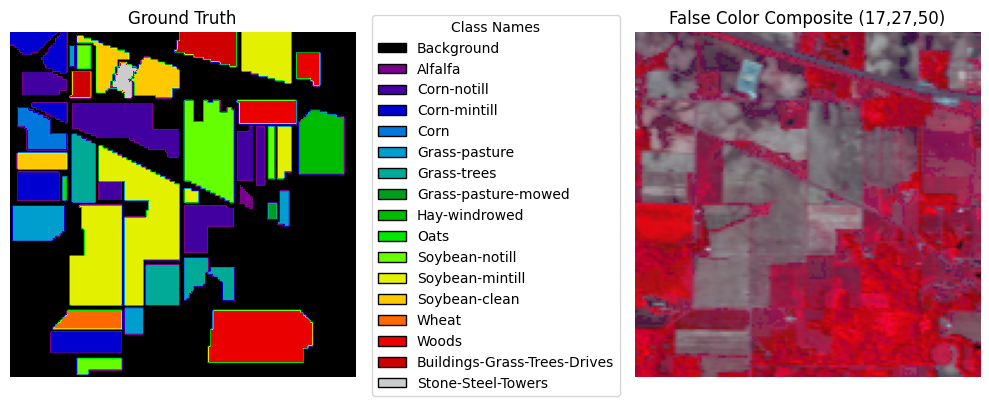

In [6]:
data, gt, class_names = show_preview(img_path, ground_truth)

In [7]:
# now we'll define the different
# methods of feature extraction

# first option =  use raw image only (complete 200 bands)
# second option = use principal components only
# third option = use (RPNet + spectral features)

In [8]:
def apply_pca_and_whiten(X, p):
    '''
    Input Parameters:
    X: feature
    p: number of PCs to keep

    Output Parameters:
    X_white: whitened feature
    pca: PCA object
    '''
    R, C, N = X.shape
    reshaped = X.reshape(-1, N)  # Shape: (R*C, N)
    pca = PCA(n_components=p)
    X_pca = pca.fit_transform(reshaped)
    X_white = StandardScaler().fit_transform(X_pca)
    return X_white.reshape(R, C, p), pca

In [9]:
def extract_random_patches_as_filters(X_white, patch_size, k):
    R, C, P = X_white.shape
    pad = patch_size // 2
    padded = np.pad(X_white, ((pad, pad), (pad, pad), (0, 0)), mode='reflect')
    patches = []

    for _ in range(k):
        i = np.random.randint(pad, R + pad)
        j = np.random.randint(pad, C + pad)
        patch = padded[i - pad:i + pad + 1, j - pad:j + pad + 1, :]
        patches.append(np.transpose(patch, (2, 0, 1)))  # CHW
    return torch.tensor(np.stack(patches), dtype=torch.float32)

In [10]:
class RPNetFixedLayer(nn.Module):
    def __init__(self, filters):
        super(RPNetFixedLayer, self).__init__()
        self.filters = nn.Parameter(filters, requires_grad=False)

    def forward(self, x):
        x = x.float()  # Ensure input is float32
        return F.conv2d(x, self.filters, padding='same')  # Same size output

In [11]:
def run_rpnet_layers(X_white, patch_size, k, L):
    current_input = X_white  # Shape: (R, C, P)
    feature_stack = []

    for layer in range(L):
        # apply PCA-whitening for 2nd layer onwards
        if layer > 0:
            current_input = apply_pca_and_whiten(current_input, 4)[0]

        # Extract filters
        filters = extract_random_patches_as_filters(current_input, patch_size, k)

        # Prepare input tensor for convolution
        inp_tensor = torch.tensor(current_input.transpose(2, 0, 1)).unsqueeze(0)  # Shape: (1, P, R, C)

        # Define and apply fixed convolution
        model = RPNetFixedLayer(filters)
        with torch.no_grad():
            output = model(inp_tensor).squeeze(0).numpy().transpose(1, 2, 0)  # Shape: (R, C, k)

        feature_stack.append(output)
        current_input = output  # Set output as input for next layer

    return np.concatenate(feature_stack, axis=-1)  # Shape: (R, C, k * L)

def combined_features(spatial_feat, data):
    spatial_feat_norm = StandardScaler().fit_transform(spatial_feat.reshape(-1, spatial_feat.shape[-1]))
    spatial_feat_norm = spatial_feat_norm.reshape(spatial_feat.shape)

    data_norm = StandardScaler().fit_transform(data.reshape(-1, data.shape[-1]))
    data_norm = data_norm.reshape(data.shape)

    combined_feat_ = np.concatenate([data_norm, spatial_feat_norm], axis=-1)
    combined_feat_norm_ = StandardScaler().fit_transform(combined_feat_.reshape(-1, combined_feat_.shape[-1]))
    # combined_feat_norm_ = combined_feat_norm_.reshape(combined_feat_.shape)

    return combined_feat_norm_

In [12]:
features = {}

# using raw image as features
features['Raw'] = data.reshape(-1, data.shape[-1])

# using PCs as features
features['PCA'] = apply_pca_and_whiten(data, 4)[0].reshape(-1, 4)

# using (RPNet + spectral features)
features['RPNet'] = combined_features(run_rpnet_layers(apply_pca_and_whiten(data, 4)[0], 20, 10, 3), data) # (pca-whitened original feature space, patch size, no. of patches, no. of layers )

In [13]:
keys = list(features.keys())
keys

['Raw', 'PCA', 'RPNet']

In [14]:
features[keys[0]].shape, features[keys[1]].shape, features[keys[2]].shape

((21025, 200), (21025, 4), (21025, 230))

In [15]:
# now we'll define the different
# methods of classification

# first option =  Gaussian Maximum Likelihood Classifier
# second option = K-NN
# third option = Parallelepiped
# fourth option = Minimum Distance
# fifth option = SVM with RBF kernel

In [16]:
def parallelepiped_predict(X_train, y_train, X_test):
    classes = np.unique(y_train)
    y_pred = np.zeros(X_test.shape[0])
    for c in classes:
        X_c = X_train[y_train == c]
        scaler = MinMaxScaler().fit(X_c)
        in_range = np.all(scaler.transform(X_test) <= 1, axis=1)  # Within bounds?
        y_pred[in_range] = c
    return y_pred

classifiers = {
    "Gaussian ML (GML)": QuadraticDiscriminantAnalysis(),
    "Parallelepiped": None, # Custom function
    "Minimum Distance": NearestCentroid(metric='euclidean'), # using Euclidean Distance
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "SVM (RBF)": SVC(kernel='rbf', C=10, gamma='scale')  # Added SVM with tuned hyperparameters
}

classifiers_class = {
    "Gaussian ML (GML)": QuadraticDiscriminantAnalysis(),
    "Parallelepiped": None, # Custom function
    "Minimum Distance": NearestCentroid(metric='euclidean'), # using Euclidean Distance
    "KNN": KNeighborsClassifier,
    "SVM": SVC
}

In [17]:
def mode_filter_exclude_zero(values):
    center = values[len(values) // 2]
    if center == 0:
        return 0  # Keep background pixel unchanged
    # Exclude 0s from neighbors before voting
    values = values[values != 0]
    if len(values) == 0:
        return center  # If all neighbors are background, keep original
    return Counter(values).most_common(1)[0][0]

In [18]:
import warnings
warnings.filterwarnings("ignore", message="The covariance matrix of class .* is not full rank.*")
warnings.filterwarnings("ignore", message="The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11.")

In [19]:
def classify(feature, method, params_clf, params_feat, data=data, features=features, gt=gt):
    key = feature.split()[0]
    if key=="PCA":
        p = params_feat['p']
        value = apply_pca_and_whiten(data, p)[0].reshape(-1, p)
    elif key=="RPNet":
        p = params_feat['p']
        patch_size = params_feat['w']
        k = params_feat['k']
        L = params_feat['L']
        value = combined_features(run_rpnet_layers(apply_pca_and_whiten(data, p)[0], patch_size, k, L), data)
    else:
        value = features[key]
    # clf = classifiers[method]
    if method == "KNN" or method == "SVM":
        clf = classifiers_class[method](**params_clf)
    else:
        clf = classifiers_class[method]

    gt_flat = gt.ravel()
    mask = gt_flat > 0
    labels = gt_flat[mask]
    feature = value[mask] if value.shape[0] == gt_flat.shape[0] else value

    # Use 80% for training and 20% for testing
    X_train, X_test, y_train, y_test = train_test_split(feature, labels, test_size=0.8, stratify=labels, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    class_counts_train, class_counts_test = {}, {}
    for label in np.unique(y_train):
        class_counts_train[int(label)] = int(np.sum(y_train == label))
    for label in np.unique(y_test):
        class_counts_test[int(label)] = int(np.sum(y_test == label))

    print(("Class Counts (Train):", class_counts_train))
    print(("Class Counts (Test):", class_counts_test))

    # Create a new figure for each feature space
    plt.figure(figsize=(25, 5))
    # plt.suptitle(f'Classification Maps for {key} Features', y=1.05, fontsize=16)

    # Create legend patches
    legend_patches = [mpatches.Patch(color=cmap(i), label=class_names[i+1])
                     for i in range(len(class_labels))]

    # Train or use classifier
    if method == "Parallelepiped":
        y_pred = parallelepiped_predict(X_train_scaled, y_train, X_test_scaled)
    else:
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    results_feat[name] = acc
    print(f"{method} Accuracy: {acc*100:.4f}")

    # Create a row dictionary
    row = {
        'Feature Type': key,
        'Classifier': method
    }

    # Find class-wise accuracies
    y_true = np.array(y_test)    # Shape: (num_test_samples,)
    y_pred = np.array(y_pred)    # Shape: (num_test_samples,)

    num_classes = np.max(y_true)
    class_accuracies = []

    for cls in range(1, num_classes + 1):
        idx = (y_true == cls)
        if np.sum(idx) == 0:
            class_accuracies.append(0)
        else:
            acc = np.sum(y_pred[idx] == cls) / np.sum(idx)
            class_accuracies.append(acc)

    # Add class-wise accuracies
    for i, acc in enumerate(class_accuracies):
        row[f'Class {class_labels[i]}'] = acc * 100

    # Calculate additional metrics
    overall_acc = accuracy_score(y_test, y_pred) * 100
    avg_acc = np.mean(class_accuracies) * 100
    kappa = cohen_kappa_score(y_test, y_pred) * 100

    # Add metrics to row
    row['Overall Accuracy'] = overall_acc
    row['Average Accuracy'] = avg_acc
    row['Kappa Coefficient'] = kappa

    # Create full prediction map (background = 0)
    full_pred = np.zeros(gt_flat.shape)

    # Get the indices of test samples in the original mask
    _, test_indices = train_test_split(np.arange(len(labels)), test_size=0.8,
                                      stratify=labels, random_state=42)
    mask_indices = np.where(mask)[0]
    full_pred[mask_indices[test_indices]] = y_pred

    # # Apply the custom majority filter with a 3x3 window
    # prediction_map = full_pred.reshape(gt.shape)
    # smoothed_map = generic_filter(prediction_map, mode_filter_exclude_zero, size=3)

    # Plot classification map
    # plt.subplot(1, 5, clf_idx+1)
    plt.imshow(full_pred.reshape(gt.shape), cmap=cmap, vmin=0, vmax=len(class_labels))
    plt.title(f'{method} using {key} Features\nAccuracy: {accuracy_score(y_test, y_pred)*100:.2f}%')
    plt.axis('off')
    plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

C:\Users\amipr\AppData\Local\Temp\ipykernel_11936\1692913657.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet', len(np.unique(gt[gt > 0])))
C:\Users\amipr\AppData\Roaming\Python\Python311\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Using Raw features

('Class Counts (Train):', {1: 9, 2: 285, 3: 166, 4: 47, 5: 97, 6: 146, 7: 6, 8: 96, 9: 4, 10: 194, 11: 491, 12: 118, 13: 41, 14: 253, 15: 77, 16: 19})
('Class Counts (Test):', {1: 37, 2: 1143, 3: 664, 4: 190, 5: 386, 6: 584, 7: 22, 8: 382, 9: 16, 10: 778, 11: 1964, 12: 475, 13: 164, 14: 1012, 15: 309, 16: 74})
Gaussian ML (GML) Accuracy: 39.4024
Parallelepiped Accuracy: 16.7683
Minimum Distance Accuracy: 42.1707
KNN (k=5) Accuracy: 70.4634
SVM (RBF) Accuracy: 83.5000


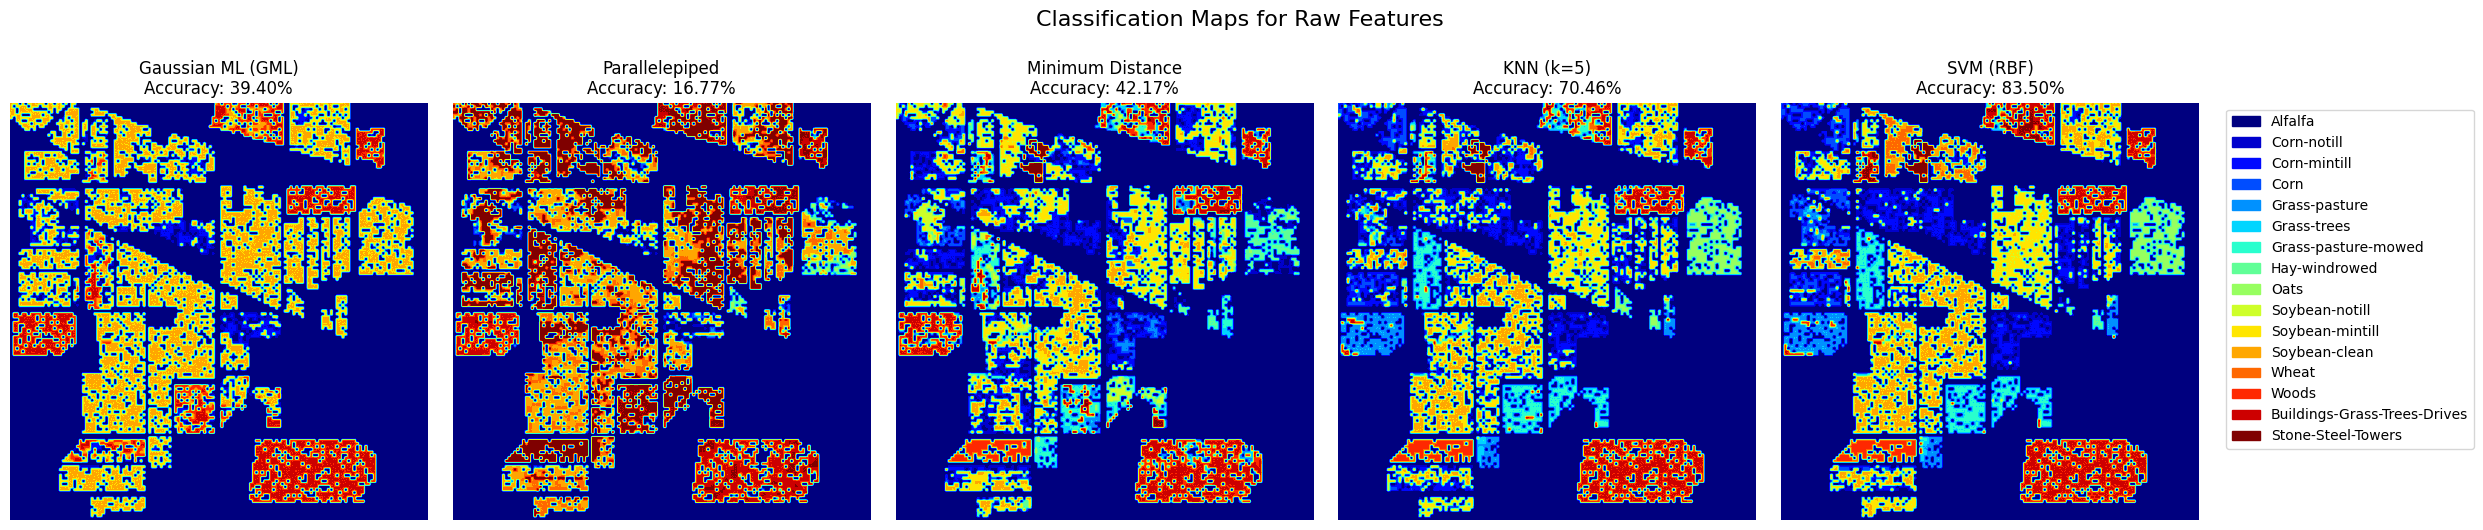



Using PCA features

('Class Counts (Train):', {1: 9, 2: 285, 3: 166, 4: 47, 5: 97, 6: 146, 7: 6, 8: 96, 9: 4, 10: 194, 11: 491, 12: 118, 13: 41, 14: 253, 15: 77, 16: 19})
('Class Counts (Test):', {1: 37, 2: 1143, 3: 664, 4: 190, 5: 386, 6: 584, 7: 22, 8: 382, 9: 16, 10: 778, 11: 1964, 12: 475, 13: 164, 14: 1012, 15: 309, 16: 74})
Gaussian ML (GML) Accuracy: 60.2073
Parallelepiped Accuracy: 8.2805
Minimum Distance Accuracy: 39.9146


C:\Users\amipr\AppData\Roaming\Python\Python311\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


KNN (k=5) Accuracy: 68.7195
SVM (RBF) Accuracy: 68.8049


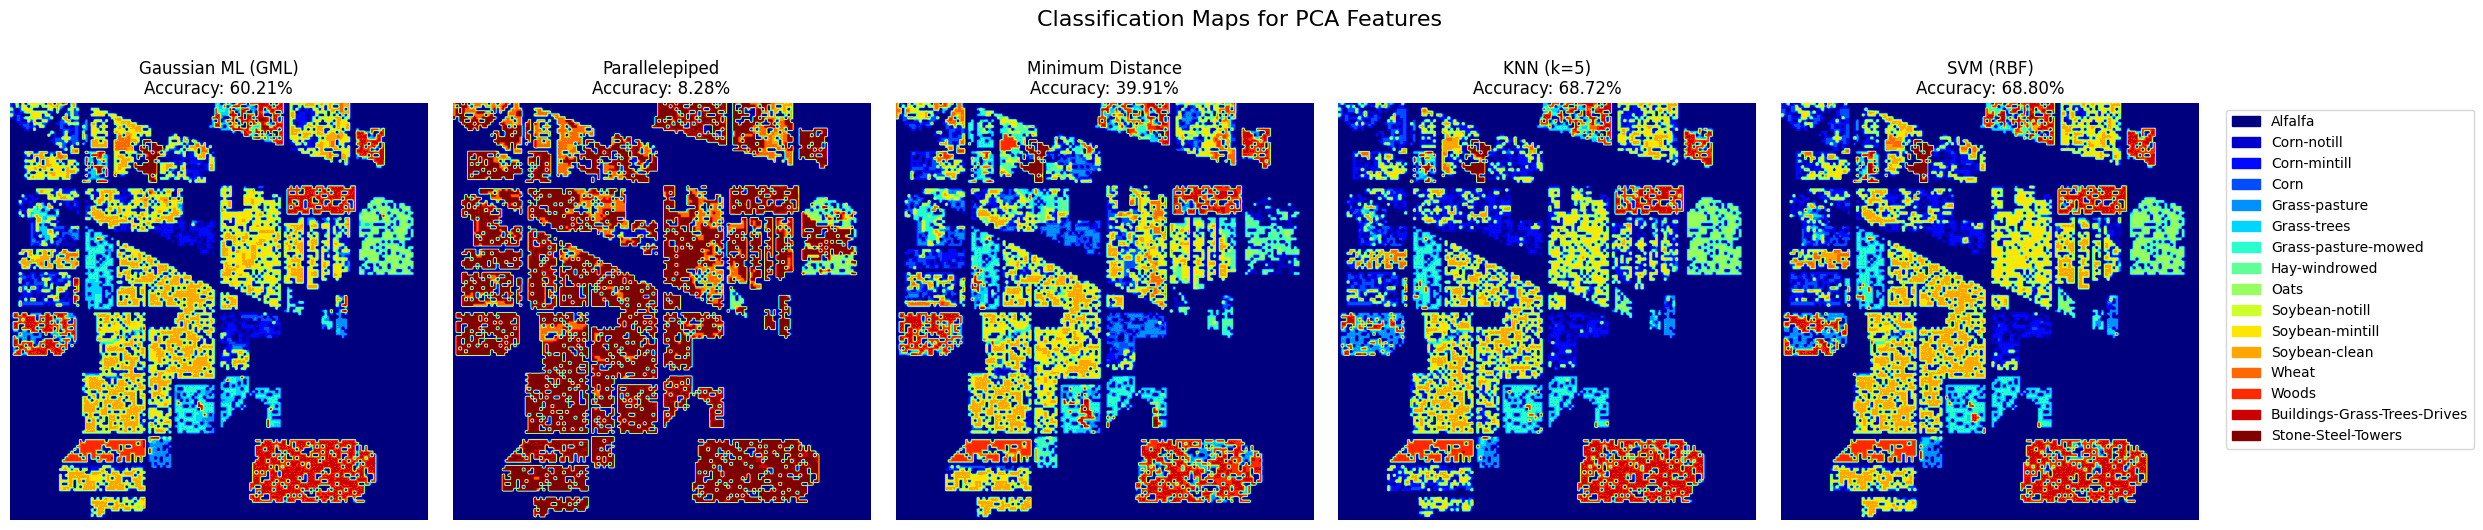



Using RPNet features

('Class Counts (Train):', {1: 9, 2: 285, 3: 166, 4: 47, 5: 97, 6: 146, 7: 6, 8: 96, 9: 4, 10: 194, 11: 491, 12: 118, 13: 41, 14: 253, 15: 77, 16: 19})
('Class Counts (Test):', {1: 37, 2: 1143, 3: 664, 4: 190, 5: 386, 6: 584, 7: 22, 8: 382, 9: 16, 10: 778, 11: 1964, 12: 475, 13: 164, 14: 1012, 15: 309, 16: 74})


C:\Users\amipr\AppData\Roaming\Python\Python311\site-packages\sklearn\discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Gaussian ML (GML) Accuracy: 41.7683
Parallelepiped Accuracy: 53.2317
Minimum Distance Accuracy: 57.3780
KNN (k=5) Accuracy: 90.9390
SVM (RBF) Accuracy: 97.0488


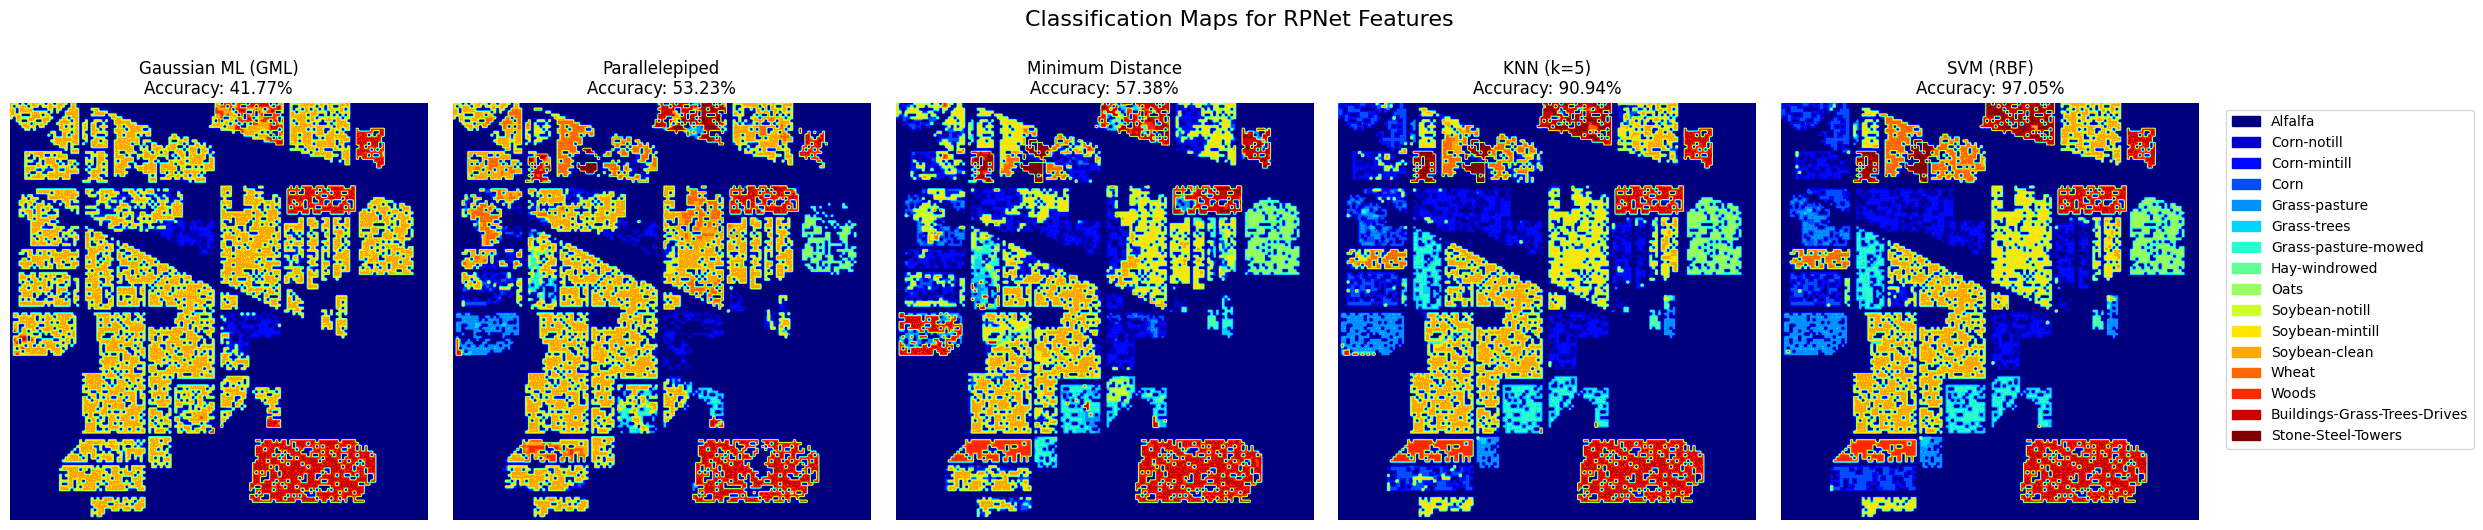

In [20]:
# results and evaluation section
import matplotlib.patches as mpatches

results = {}
class_results = []
cmap = plt.cm.get_cmap('jet', len(np.unique(gt[gt > 0])))
class_labels = np.unique(gt[gt > 0])

for feat_idx, key in enumerate(features.keys()):
    value = features[key]
    print(f"Using {key} features\n")

    gt_flat = gt.ravel()
    mask = gt_flat > 0
    labels = gt_flat[mask]
    feature = value[mask] if value.shape[0] == gt_flat.shape[0] else value

    # Use 80% for training and 20% for testing
    X_train, X_test, y_train, y_test = train_test_split(feature, labels, test_size=0.8, stratify=labels, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    class_counts_train, class_counts_test = {}, {}
    for label in np.unique(y_train):
        class_counts_train[int(label)] = int(np.sum(y_train == label))
    for label in np.unique(y_test):
        class_counts_test[int(label)] = int(np.sum(y_test == label))

    print(("Class Counts (Train):", class_counts_train))
    print(("Class Counts (Test):", class_counts_test))

    # Create a new figure for each feature space
    plt.figure(figsize=(25, 5))
    plt.suptitle(f'Classification Maps for {key} Features', y=1.05, fontsize=16)

    # Create legend patches
    legend_patches = [mpatches.Patch(color=cmap(i), label=class_names[i+1])
                     for i in range(len(class_labels))]

    results_feat = {}
    for clf_idx, (name, clf) in enumerate(classifiers.items()):
        # Train or use classifier
        if name == "Parallelepiped":
            y_pred = parallelepiped_predict(X_train_scaled, y_train, X_test_scaled)
        else:
            clf.fit(X_train_scaled, y_train)
            y_pred = clf.predict(X_test_scaled)

        acc = accuracy_score(y_test, y_pred)
        results_feat[name] = acc
        print(f"{name} Accuracy: {acc*100:.4f}")

        # Create a row dictionary
        row = {
            'Feature Type': key,
            'Classifier': name
        }

        # Find class-wise accuracies
        y_true = np.array(y_test)    # Shape: (num_test_samples,)
        y_pred = np.array(y_pred)    # Shape: (num_test_samples,)

        num_classes = np.max(y_true)
        class_accuracies = []

        for cls in range(1, num_classes + 1):
            idx = (y_true == cls)
            if np.sum(idx) == 0:
                class_accuracies.append(0)
            else:
                acc = np.sum(y_pred[idx] == cls) / np.sum(idx)
                class_accuracies.append(acc)

        # Add class-wise accuracies
        for i, acc in enumerate(class_accuracies):
            row[f'Class {class_labels[i]}'] = acc * 100

        # Calculate additional metrics
        overall_acc = accuracy_score(y_test, y_pred) * 100
        avg_acc = np.mean(class_accuracies) * 100
        kappa = cohen_kappa_score(y_test, y_pred) * 100

        # Add metrics to row
        row['Overall Accuracy'] = overall_acc
        row['Average Accuracy'] = avg_acc
        row['Kappa Coefficient'] = kappa

        class_results.append(row)

        # Create full prediction map (background = 0)
        full_pred = np.zeros(gt_flat.shape)

        # Get the indices of test samples in the original mask
        _, test_indices = train_test_split(np.arange(len(labels)), test_size=0.8,
                                          stratify=labels, random_state=42)
        mask_indices = np.where(mask)[0]
        full_pred[mask_indices[test_indices]] = y_pred

        # # Apply the custom majority filter with a 3x3 window
        # prediction_map = full_pred.reshape(gt.shape)
        # smoothed_map = generic_filter(prediction_map, mode_filter_exclude_zero, size=3)

        # Plot classification map
        plt.subplot(1, 5, clf_idx+1)
        plt.imshow(full_pred.reshape(gt.shape), cmap=cmap, vmin=0, vmax=len(class_labels))
        plt.title(f'{name}\nAccuracy: {accuracy_score(y_test, y_pred)*100:.2f}%')
        plt.axis('off')

        # Add legend to the last subplot
        if clf_idx == 4:
            plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

    results[key] = results_feat
    print('\n')

In [21]:
import pandas as pd

In [22]:
# Prepare the data for the DataFrame
data_rows = class_results

# Get all unique class labels from your data
class_labels = np.unique(gt[gt > 0])

# Create DataFrame
class_accuracy_df = pd.DataFrame(data_rows)

# Set multi-index
class_accuracy_df.set_index(['Feature Type', 'Classifier'], inplace=True)

# Reorder columns to put metrics at the end
cols = [f'Class {cls}' for cls in class_labels] + ['Overall Accuracy', 'Average Accuracy', 'Kappa Coefficient']
class_accuracy_df = class_accuracy_df[cols]

# Round all values to 2 decimal places
class_accuracy_df = class_accuracy_df.round(2)

# Display the DataFrame
print("Comprehensive Classification Performance Metrics (%):")
display(class_accuracy_df)

Comprehensive Classification Performance Metrics (%):


Class 1  Class 2  Class 3  Class 4  Class 5   
Feature Type Classifier                                                       
Raw          Gaussian ML (GML)     0.00    25.46     0.00     0.00     0.00  \
             Parallelepiped        0.00     5.42     0.30    11.58     2.07   
             Minimum Distance     67.57    43.74    15.96    41.05     9.33   
             KNN (k=5)             5.41    64.04    54.22    18.42    84.20   
             SVM (RBF)            62.16    80.23    62.65    61.05    85.49   
PCA          Gaussian ML (GML)    37.84    29.57    30.72    23.16    38.34   
             Parallelepiped        0.00     3.06     0.00     0.00     0.00   
             Minimum Distance     62.16     6.74    20.93    45.26     9.33   
             KNN (k=5)             2.70    62.47    50.60    23.16    66.84   
             SVM (RBF)             0.00    47.51    41.72    30.00    55.44   
RPNet        Gaussian ML (GML)     0.00    39.72     0.00     0.00     0.00   
             Parallelepiped        0.00    24.85    15.51     8.42    50.00   
             Minimum Distance     83.78    51.01    24.10    49.47    21.24   
             KNN (k=5)            83.78    89.41    81.33    76.32    91.97   
             SVM (RBF)            94.59    96.06    94.28    93.68    95.34   

                                Class 6  Class 7  Class 8  Class 9  Class 10   
Feature Type Classifier                                                        
Raw          Gaussian ML (GML)     0.00     0.00     0.00     0.00      0.00  \
             Parallelepiped        1.88     0.00    28.80     0.00      0.00   
             Minimum Distance     42.98   100.00    26.44    93.75     47.69   
             KNN (k=5)            96.75    18.18    98.43    18.75     67.48   
             SVM (RBF)            98.12    86.36    97.91    31.25     76.35   
PCA          Gaussian ML (GML)    87.33    50.00    97.12     0.00     38.17   
             Parallelepiped        0.00     0.00    44.76     0.00      0.00   
             Minimum Distance     69.86    95.45    38.22    68.75     20.18   
             KNN (k=5)            94.35    50.00    99.74     0.00     71.98   
             SVM (RBF)            94.86    72.73    99.74     0.00     67.61   
RPNet        Gaussian ML (GML)     0.00     0.00     0.00     0.00      0.00   
             Parallelepiped       36.99     0.00    58.12     0.00      7.07   
             Minimum Distance     61.47   100.00    96.07   100.00     52.06   
             KNN (k=5)            98.80    95.45   100.00    31.25     91.13   
             SVM (RBF)            99.66    95.45   100.00   100.00     97.81   

                                Class 11  Class 12  Class 13  Class 14   
Feature Type Classifier                                                  
Raw          Gaussian ML (GML)     98.27      0.00      0.00     99.80  \
             Parallelepiped        18.53     31.16      0.00     44.76   
             Minimum Distance      46.18      1.68     96.95     73.52   
             KNN (k=5)             74.75     30.74    100.00     93.38   
             SVM (RBF)             87.83     74.53    100.00     97.53   
PCA          Gaussian ML (GML)     81.06     25.47     96.34     95.95   
             Parallelepiped         1.17     42.11      0.00      1.88   
             Minimum Distance      61.25      3.58     93.90     68.08   
             KNN (k=5)             72.45     32.84     98.78     90.42   
             SVM (RBF)             85.90     29.68     99.39     92.39   
RPNet        Gaussian ML (GML)    100.00      0.00      0.00     99.51   
             Parallelepiped        92.36     69.26     51.22     83.60   
             Minimum Distance      64.41     27.37    100.00     79.05   
             KNN (k=5)             93.08     72.84    100.00     98.62   
             SVM (RBF)             97.30     95.37    100.00     99.01   

                                Class 15  Class 16  Overall Accuracy

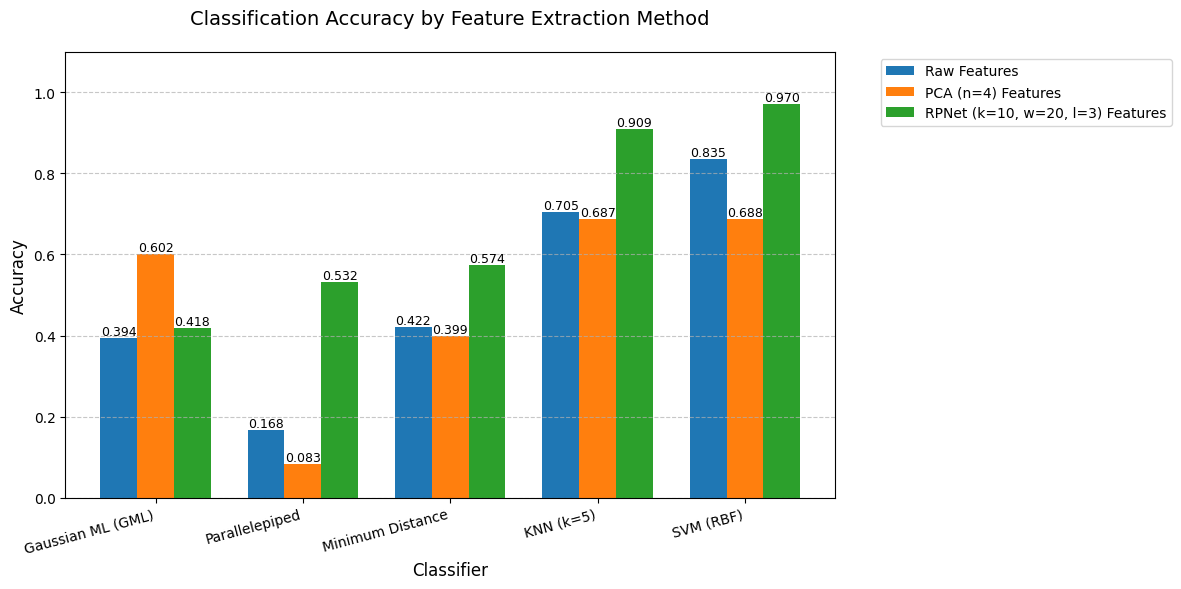

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

res = pd.DataFrame(results)

# Create DataFrame from the provided table
val = {
    'Classifier': res.index,
    'feature_raw': res.iloc[:,0].values,
    'feature_pca': res.iloc[:,1].values,
    'features_rpnet': res.iloc[:,2].values
}

df = pd.DataFrame(val)

# Plot settings
plt.figure(figsize=(12, 6))
bar_width = 0.25
index = np.arange(len(df['Classifier']))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Distinct colors for each feature type

# Create bars
bar1 = plt.bar(index, df['feature_raw'], bar_width, color=colors[0], label='Raw Features')
bar2 = plt.bar(index + bar_width, df['feature_pca'], bar_width, color=colors[1], label='PCA (n=4) Features')
bar3 = plt.bar(index + 2*bar_width, df['features_rpnet'], bar_width, color=colors[2], label='RPNet (k=10, w=20, l=3) Features')

# Add labels and title
plt.xlabel('Classifier', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Classification Accuracy by Feature Extraction Method', fontsize=14, pad=20)
plt.xticks(index + bar_width, df['Classifier'], rotation=15, ha='right')
plt.ylim(0, 1.1)

# Add value labels on top of each bar
for bars in [bar1, bar2, bar3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.3f}',
                 ha='center', va='bottom', fontsize=9)

# Add legend and grid
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()

In [24]:
# Define the experiment
n_components_range = range(1, 11)  # Test 1 to 10 PCs
results_pca = {'n_components': [], 'accuracy': [], 'feature_variance': []}

for n in n_components_range:
    # Extract PCA features
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(data.reshape(-1, data.shape[-1]))

    # Prepare data (exclude background)
    X = X_pca[gt_flat > 0]
    y = gt_flat[gt_flat > 0]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, stratify=y, random_state=42)

    # Standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train SVM
    clf = SVC(kernel='rbf', C=10, gamma='scale')
    clf.fit(X_train_scaled, y_train)

    # Evaluate
    acc = accuracy_score(y_test, clf.predict(X_test_scaled))

    # Store results
    results_pca['n_components'].append(n)
    results_pca['accuracy'].append(acc)
    results_pca['feature_variance'].append(np.sum(pca.explained_variance_ratio_))

# Convert to DataFrame
results_df = pd.DataFrame(results_pca)

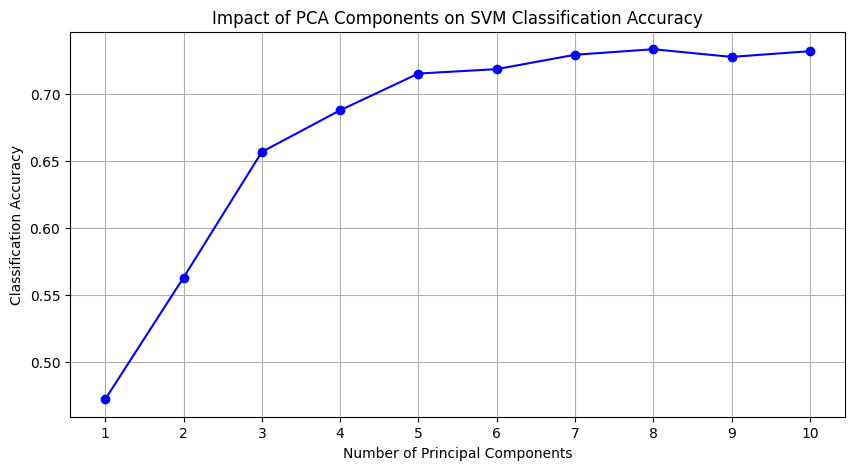

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(results_df['n_components'], results_df['accuracy'], marker='o', linestyle='-', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Classification Accuracy')
plt.title('Impact of PCA Components on SVM Classification Accuracy')
plt.grid(True)
plt.xticks(range(1, 11))
plt.show()

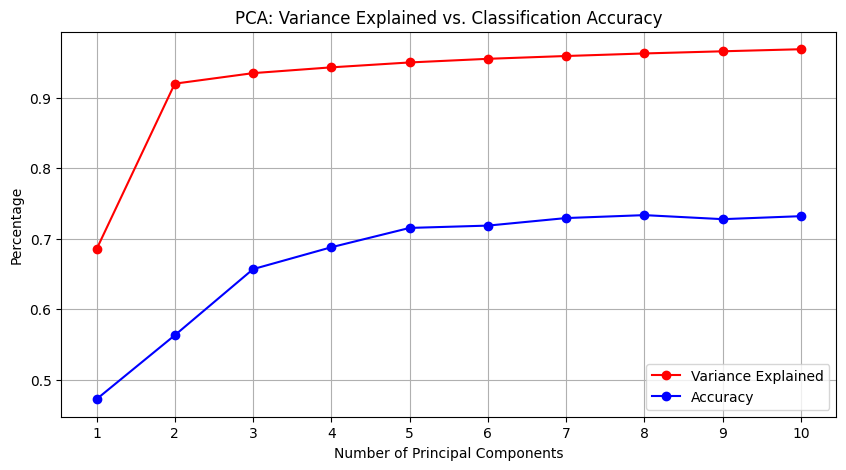

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(results_df['n_components'], results_df['feature_variance'],
         marker='o', linestyle='-', color='r', label='Variance Explained')
plt.plot(results_df['n_components'], results_df['accuracy'],
         marker='o', linestyle='-', color='b', label='Accuracy')
plt.xlabel('Number of Principal Components')
plt.ylabel('Percentage')
plt.title('PCA: Variance Explained vs. Classification Accuracy')
plt.legend()
plt.grid(True)
plt.xticks(range(1, 11))
plt.show()

In [27]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define k values to test
k_values = range(1, 8)  # Testing k from 1 to 7
results = {'k': [], 'feature_type': [], 'accuracy': []}

for feature_name, feature_data in features.items():
    # Prepare data (exclude background)
    gt_flat = gt.ravel()
    X = feature_data[gt_flat > 0]
    y = gt_flat[gt_flat > 0]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42)

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Test different k values
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_scaled, y_train)
        acc = knn.score(X_test_scaled, y_test)

        # Store results
        results['k'].append(k)
        results['feature_type'].append(feature_name)
        results['accuracy'].append(acc)

# Convert to DataFrame
results_df = pd.DataFrame(results)

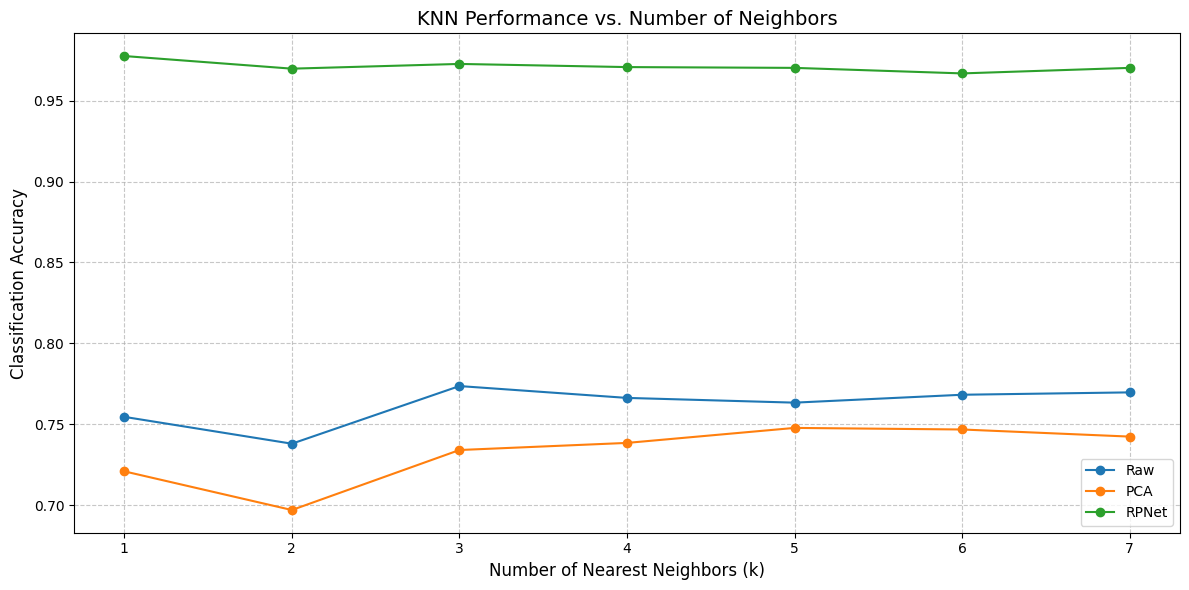

In [28]:
plt.figure(figsize=(12, 6))
for feature_type in features.keys():
    subset = results_df[results_df['feature_type'] == feature_type]
    plt.plot(subset['k'], subset['accuracy'],
             marker='o', linestyle='-',
             label=feature_type)

plt.xlabel('Number of Nearest Neighbors (k)', fontsize=12)
plt.ylabel('Classification Accuracy', fontsize=12)
plt.title('KNN Performance vs. Number of Neighbors', fontsize=14)
plt.xticks(range(1, 8, 1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()